In [1]:
# pip install goatools

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy

# ==========================
# 1. Read gene lists
# ==========================
# Read DEGs from "DEG.txt"
deg_list = []
with open("DEG.txt", "r") as f_deg:
    for line in f_deg:
        gene = line.strip()
        if gene:
            deg_list.append(gene)

# Read background genes from "all_genes.txt"
background_genes = []
with open("all_genes.txt", "r") as f_bg:
    for line in f_bg:
        gene = line.strip()
        if gene:
            background_genes.append(gene)

print(f"Number of DEGs: {len(deg_list)}")
print(f"Number of background genes: {len(background_genes)}")

Number of DEGs: 332
Number of background genes: 17581


In [3]:
import os
from goatools.associations import read_gaf
# ==========================
# 2. Load GO data
# ==========================
obo_dag_file = "go-basic.obo"
gaf_file = "gene_annotations_tair.gaf"

# 2a. Load the ontology (DAG)
if not os.path.exists(obo_dag_file):
    raise FileNotFoundError(f"Could not find go.obo at {obo_dag_file}")
go_dag = GODag(obo_dag_file)

# 2b. Read the GAF file
if not os.path.exists(gaf_file):
    raise FileNotFoundError(f"Could not find GAF file at {gaf_file}")
gene2go_map = read_gaf(gaf_file)  # Returns dict: {gene: set([go1, go2, ...])}

print(f"Number of genes in GAF mapping: {len(gene2go_map)}")

go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms
HMS:0:00:03.357853 224,764 annotations READ: gene_annotations_tair.gaf 
23336 IDs in loaded association branch, BP
Number of genes in GAF mapping: 23336


In [4]:
# ==========================
# 3. Run GO enrichment
# ==========================
goeaobj = GOEnrichmentStudy(
    background_genes,
    gene2go_map,            
    go_dag,
    propagate_counts=True,
    alpha=0.05,             # significance threshold
    methods=['fdr_bh']      # multiple test correction
)

goea_results_all = goeaobj.run_study(deg_list)

# Filter for significant results (FDR-corrected p-value < 0.05)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

print(f"Significant results: {len(goea_results_sig)}")

# Convert results to a DataFrame
results_df = pd.DataFrame([
    {
        "GO_ID": r.GO,
        "Term": r.goterm.name,
        "Namespace": r.goterm.namespace,
        "p_uncorrected": r.p_uncorrected,
        "p_fdr_bh": r.p_fdr_bh,
        "study_count": r.study_count,    # <--- Add this
        "study_n": r.study_n,            # total number of query genes
        "pop_count": r.pop_count,
        "pop_n": r.pop_n,
        "Ratio_in_study": f"{r.study_count}/{r.study_n}",
        "Ratio_in_pop": f"{r.pop_count}/{r.pop_n}",
        "Fold_Enrichment": (
            (r.study_count / r.study_n) / (r.pop_count / r.pop_n)
        ) if r.pop_count != 0 else np.nan
    }
    for r in goea_results_sig
])

print(results_df.head())

results_df["neg_log10_p"] = -np.log10(results_df["p_fdr_bh"] + 1e-300)


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 55%  9,720 of 17,581 population items found in association

Runing  Ontology Analysis: current study set of 332 IDs.
 65%    215 of    332 study items found in association
100%    332 of    332 study items found in population(17581)
Calculating 4,681 uncorrected p-values using fisher_scipy_stats
   4,681 terms are associated with  9,720 of 17,581 population items
     972 terms are associated with    215 of    332 study items
  METHOD fdr_bh:
      55 GO terms found significant (< 0.05=alpha) ( 52 enriched +   3 purified): statsmodels fdr_bh
     215 study items associated with significant GO IDs (enriched)
      24 study items associated with significant GO IDs (purified)
Significant results: 55
        GO_ID                                          Term  \
0  GO:0071456                  cellular response to hypoxia   
1  GO:0036294  cellular response to decreased oxygen levels   
2  GO:0071453            cellul

In [5]:
results_df.sort_values('Fold_Enrichment', inplace=True)
results_df

,GO_ID,Term,Namespace,p_uncorrected,p_fdr_bh,study_count,study_n,pop_count,pop_n,Ratio_in_study,Ratio_in_pop,Fold_Enrichment,neg_log10_p
53,GO:0090304,nucleic acid metabolic process,biological_process,4.879623e-05,7.368231e-03,2,332,809,17581,2/332,809/17581,0.130914,2.132637
52,GO:0006139,nucleobase-containing compound metabolic process,biological_process,3.987200e-05,6.855872e-03,4,332,1013,17581,4/332,1013/17581,0.209101,2.163937
54,GO:0043170,macromolecule metabolic process,biological_process,5.081749e-05,7.433647e-03,22,332,2409,17581,22/332,2409/17581,0.483606,2.128798
46,GO:0008150,biological_process,biological_process,4.367641e-04,4.088985e-02,215,332,9720,17581,215/332,9720/17581,1.171326,1.388384
7,GO:0050896,response to stimulus,biological_process,1.608091e-12,9.409340e-10,123,332,3586,17581,123/332,3586/17581,1.816353,9.026441
38,GO:1901700,response to oxygen-containing compound,biological_process,1.455898e-04,1.622633e-02,38,332,1053,17581,38/332,1053/17581,1.911000,1.789780
13,GO:0009628,response to abiotic stimulus,biological_process,2.178777e-07,7.284898e-05,66,332,1818,17581,66/332,1818/17581,1.922452,4.137577
29,GO:0051716,cellular response to stimulus,biological_process,5.608375e-05,7.955395e-03,37,332,982,17581,37/332,982/17581,1.995243,2.099338
8,GO:0006950,response to stress,biological_process,1.383987e-11,7.198269e-09,92,332,2408,17581,92/332,2408/17581,2.023191,8.142772
19,GO:0009605,response to external stimulus,biological_process,3.586263e-06,8.393648e-04,41,332,1008,17581,41/332,1008/17581,2.153916,3.076049


In [6]:
results_df_top20 = results_df.sort_values(by = 'Fold_Enrichment', ascending=False).head(20)
results_df_top20.sort_values('Fold_Enrichment', inplace=True)

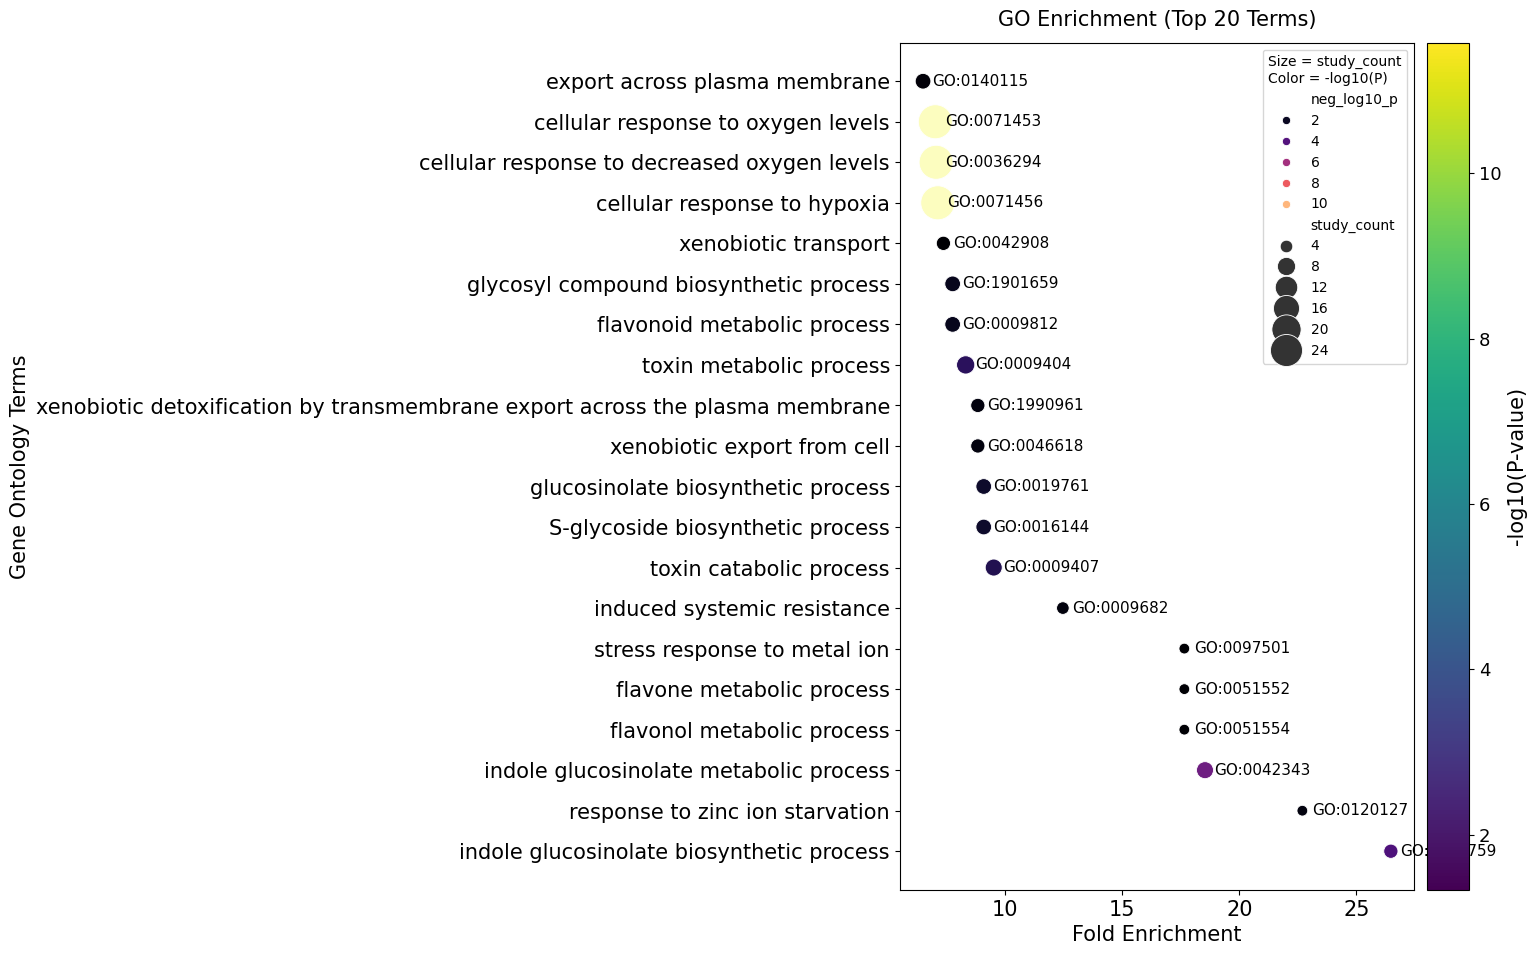

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# "results_df" should have columns:
#  "Fold_Enrichment", "Term", "study_count", "neg_log10_p", "GO_ID"

# 1. Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 11))

# 2. Plot with Seaborn on the specified Axes
#    Pass legend="brief" so Seaborn generates a combined legend for size/color
scatter = sns.scatterplot(
    data=results_df_top20,
    x="Fold_Enrichment",
    y="Term",
    size="study_count",          # Dot size = e.g. number of DEGs
    hue="neg_log10_p",           # Dot color scale = -log10(P)
    sizes=(60, 600),
    palette="magma",
    ax=ax               # Create a simpler legend we can reposition
)

# 3. Annotate each point with GO ID above/beside the dot
#    Use row["Term"] for y so text is placed accurately
for _, row in results_df_top20.iterrows():
    ax.text(
        x=row["Fold_Enrichment"] + 0.4,
        y=row["Term"],
        s=row["GO_ID"],
        va="center",
        fontsize=11
    )

# 4. Customize axes labels and title
ax.set_title("GO Enrichment (Top 20 Terms)", fontsize=15, y = 1.01)
ax.set_xlabel("Fold Enrichment", fontsize=15)
ax.set_ylabel("Gene Ontology Terms", fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=15)


# 5. Create a scalar mappable for the colorbar (for neg_log10_p)
norm = plt.Normalize(results_df_top20["neg_log10_p"].min(),
                     results_df_top20["neg_log10_p"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# 6. Attach the colorbar to the same figure/axes
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("-log10(P-value)", fontsize = 15)
cbar.ax.tick_params(labelsize=13)


# 7. Manually reposition legend outside the plot
#    Grab the handles/labels from the scatter Axes
handles, labels = scatter.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    title="Size = study_count\nColor = -log10(P)",
    loc = 'best',
    bbox_to_anchor=(1, 1),  # Move legend box to the right

)

plt.show()

fig.savefig("go_enrichment_plot.png", dpi=300, bbox_inches="tight")